# Data validation
See if my data is correct given the capturer

In [177]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import math

DATA_DIR = Path("data")
files = sorted(DATA_DIR.glob("*.csv"))

print(f"Total: {len(files)} files")
print(f"BTC: {len([f for f in files if f.name.startswith('btc-')])}")
print(f"ETH: {len([f for f in files if f.name.startswith('eth-')])}")
print(f"SOL: {len([f for f in files if f.name.startswith('sol-')])}")
print(f"XRP: {len([f for f in files if f.name.startswith('xrp-')])}")

Total: 32 files
BTC: 8
ETH: 8
SOL: 8
XRP: 8


In [178]:
filepath = DATA_DIR / "sol-2026-01-29-21_15-21_30.csv"

meta = {}
with open(filepath) as f:
    for line in f:
        if line.startswith("# end_market_metadata"):
            break
        if line.startswith("# ") and "=" in line:
            k, v = line[2:].strip().split("=", 1)
            meta[k] = v

print("Metadata:")
for k, v in meta.items():
    print(f"  {k}: {v}")

df = pd.read_csv(filepath, comment='#')
print(f"\nRows: {len(df)}")
df.head(3)

Metadata:
  slug: sol-updown-15m-1769721300
  asset: sol
  start_time: 2026-01-29T21:15:00Z
  closed_time: 2026-01-29T21:30:00+00:00
  yes_token: 52815105764436128290127585650536047196851248695644739453355994022546423509676
  no_token: 41441281175480320483270623101378091003500868350375854508457466372179666556011
  resolved_outcome: Down

Rows: 73536


,slug,asset,outcome,exchange_timestamp_ms,exchange_timestamp_utc,insertion_timestamp_utc,chainlink_price_usd,chainlink_timestamp_ms,chainlink_age_ms,binance_price_usdt,...,bid_price_2,bid_price_3,bid_price_4,bid_price_5,bid_size_1,bid_size_2,bid_size_3,bid_size_4,bid_size_5,chainlink_found
0,sol-updown-15m-1769721300,sol,YES,1769721305096,2026-01-29T21:15:05.096000+00:00,2026-01-29T21:15:05.168900+00:00,117.069565,1769721303000,2096,117.28,...,0.43,0.42,0.41,0.40,340.0,330.0,312.50,307.50,313.0,True
1,sol-updown-15m-1769721300,sol,NO,1769721305096,2026-01-29T21:15:05.096000+00:00,2026-01-29T21:15:05.177722+00:00,117.069565,1769721303000,2096,117.28,...,0.54,0.53,0.52,0.51,5.0,7.5,24.25,28.33,7.5,True
2,sol-updown-15m-1769721300,sol,YES,1769721305277,2026-01-29T21:15:05.277000+00:00,2026-01-29T21:15:05.205172+00:00,117.069565,1769721303000,2277,117.28,...,0.43,0.42,0.41,0.40,340.0,322.5,312.50,307.50,313.0,True


In [179]:

df["exchange_dt"]  = pd.to_datetime(df["exchange_timestamp_ms"], unit="ms", utc=True, errors="coerce")
df["chainlink_dt"] = pd.to_datetime(df["chainlink_timestamp_ms"], unit="ms", utc=True, errors="coerce")
df["binance_dt"]   = pd.to_datetime(df["binance_timestamp_ms"], unit="ms", utc=True, errors="coerce")

cl_found = df["chainlink_timestamp_ms"].notna() & df["chainlink_price_usd"].notna()
bn_found = df["binance_timestamp_ms"].notna()   & df["binance_price_usdt"].notna()

cl_ok = cl_found & df["exchange_timestamp_ms"].notna() & (df["chainlink_timestamp_ms"] <= df["exchange_timestamp_ms"])
bn_ok = bn_found & df["exchange_timestamp_ms"].notna() & (df["binance_timestamp_ms"]   <= df["exchange_timestamp_ms"])

cl_age = (df["exchange_timestamp_ms"] - df["chainlink_timestamp_ms"]).where(cl_found)
bn_age = (df["exchange_timestamp_ms"] - df["binance_timestamp_ms"]).where(bn_found)

print("ASOF sanity (found inferred)")
print(f"rows={len(df)}")
print(f"chainlink found={cl_found.mean():.2%}  asof_ok={cl_ok.mean():.2%}  bad_order={(cl_found & ~cl_ok).mean():.2%}")
print(f"binance   found={bn_found.mean():.2%}  asof_ok={bn_ok.mean():.2%}  bad_order={(bn_found & ~bn_ok).mean():.2%}")

print("\nAge (ms) quantiles vs exchange timestamp")
print("chainlink:", cl_age.dropna().quantile([.5,.9,.99]).to_dict())
print("binance:  ", bn_age.dropna().quantile([.5,.9,.99]).to_dict())

ASOF sanity (found inferred)
rows=73536
chainlink found=100.00%  asof_ok=100.00%  bad_order=0.00%
binance   found=100.00%  asof_ok=100.00%  bad_order=0.00%

Age (ms) quantiles vs exchange timestamp
chainlink: {0.5: 1688.0, 0.9: 2305.0, 0.99: 4219.9499999999825}
binance:   {0.5: 746.0, 0.9: 1180.0, 0.99: 1301.0}


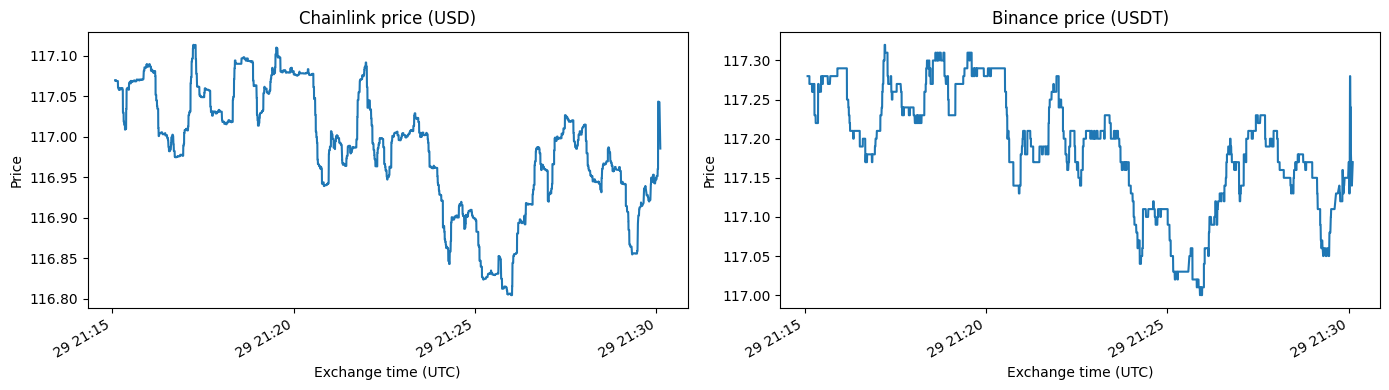

In [180]:
p = df.sort_values("exchange_dt")
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

m = p["exchange_dt"].notna() & p["chainlink_price_usd"].notna() & p["chainlink_timestamp_ms"].notna()
ax[0].plot(p.loc[m, "exchange_dt"], p.loc[m, "chainlink_price_usd"])
ax[0].set_title("Chainlink price (USD)")
ax[0].set_xlabel("Exchange time (UTC)")
ax[0].set_ylabel("Price")

m = p["exchange_dt"].notna() & p["binance_price_usdt"].notna() & p["binance_timestamp_ms"].notna()
ax[1].plot(p.loc[m, "exchange_dt"], p.loc[m, "binance_price_usdt"])
ax[1].set_title("Binance price (USDT)")
ax[1].set_xlabel("Exchange time (UTC)")
ax[1].set_ylabel("Price")

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Infer Price to beat system

Since polymarket does not programmatically expose the 'price to beat' which is used to settle the bets I checked out if we can use the first couple seconds from market open. And that is correct for most cases. 

In [181]:
ASSETS = ["btc", "eth", "sol", "xrp"]

N_MARKETS_PER_ASSET = 5 

def load_n_per_asset(data_dir=DATA_DIR, assets=ASSETS, n=N_MARKETS_PER_ASSET) -> pd.DataFrame:
    dfs = []
    for a in assets:
        files = sorted(data_dir.glob(f"{a}-*.csv"))[:n]
        for fp in files:
            meta = {}
            with open(fp, "r", encoding="utf-8") as f:
                for line in f:
                    if line.startswith("# end_market_metadata"):
                        break
                    if line.startswith("# ") and "=" in line:
                        k, v = line[2:].strip().split("=", 1)
                        meta[k] = v

            df = pd.read_csv(fp, comment="#")
            df["file"] = fp.name
            df["slug"] = meta.get("slug")
            df["asset"] = meta.get("asset", a)
            df["start_time"] = meta.get("start_time")
            df["closed_time"] = meta.get("closed_time")
            df["resolved_outcome"] = meta.get("resolved_outcome")

            dfs.append(df)

    out = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

    if "exchange_timestamp_ms" in out.columns:
        out["exchange_dt"] = pd.to_datetime(out["exchange_timestamp_ms"], unit="ms", utc=True, errors="coerce")
    if "chainlink_timestamp_ms" in out.columns:
        out["chainlink_dt"] = pd.to_datetime(out["chainlink_timestamp_ms"], unit="ms", utc=True, errors="coerce")
    if "binance_timestamp_ms" in out.columns:
        out["binance_dt"] = pd.to_datetime(out["binance_timestamp_ms"], unit="ms", utc=True, errors="coerce")

    return out


df = load_n_per_asset()
print("rows:", len(df), "| markets:", df["slug"].nunique(), "| by asset:\n", df["asset"].value_counts())
display(df.head(3))

print(df['slug'].unique())

rows: 3012230 | markets: 20 | by asset:
 asset
btc    1326548
eth    1074339
sol     322080
xrp     289263
Name: count, dtype: int64


,slug,asset,outcome,exchange_timestamp_ms,exchange_timestamp_utc,insertion_timestamp_utc,chainlink_price_usd,chainlink_timestamp_ms,chainlink_age_ms,binance_price_usdt,...,bid_size_4,bid_size_5,chainlink_found,file,start_time,closed_time,resolved_outcome,exchange_dt,chainlink_dt,binance_dt
0,btc-updown-15m-1769721300,btc,YES,1769721305252,2026-01-29T21:15:05.252000+00:00,2026-01-29T21:15:05.194755+00:00,84257.747982,1769721303000,2252,84412.66,...,2783.5,1632.0,True,btc-2026-01-29-21_15-21_30.csv,2026-01-29T21:15:00Z,2026-01-29T21:30:00+00:00,Down,2026-01-29 21:15:05.252000+00:00,2026-01-29 21:15:03+00:00,2026-01-29 21:15:04+00:00
1,btc-updown-15m-1769721300,btc,YES,1769721305259,2026-01-29T21:15:05.259000+00:00,2026-01-29T21:15:05.194794+00:00,84257.747982,1769721303000,2259,84412.66,...,2783.5,1632.0,True,btc-2026-01-29-21_15-21_30.csv,2026-01-29T21:15:00Z,2026-01-29T21:30:00+00:00,Down,2026-01-29 21:15:05.259000+00:00,2026-01-29 21:15:03+00:00,2026-01-29 21:15:04+00:00
2,btc-updown-15m-1769721300,btc,YES,1769721305260,2026-01-29T21:15:05.260000+00:00,2026-01-29T21:15:05.194813+00:00,84257.747982,1769721303000,2260,84412.66,...,2783.5,1632.0,True,btc-2026-01-29-21_15-21_30.csv,2026-01-29T21:15:00Z,2026-01-29T21:30:00+00:00,Down,2026-01-29 21:15:05.260000+00:00,2026-01-29 21:15:03+00:00,2026-01-29 21:15:04+00:00


['btc-updown-15m-1769721300' 'btc-updown-15m-1769722200'
 'btc-updown-15m-1769723100' 'btc-updown-15m-1769724000'
 'btc-updown-15m-1769724900' 'eth-updown-15m-1769721300'
 'eth-updown-15m-1769722200' 'eth-updown-15m-1769723100'
 'eth-updown-15m-1769724000' 'eth-updown-15m-1769724900'
 'sol-updown-15m-1769721300' 'sol-updown-15m-1769722200'
 'sol-updown-15m-1769723100' 'sol-updown-15m-1769724000'
 'sol-updown-15m-1769724900' 'xrp-updown-15m-1769721300'
 'xrp-updown-15m-1769722200' 'xrp-updown-15m-1769723100'
 'xrp-updown-15m-1769724000' 'xrp-updown-15m-1769724900']


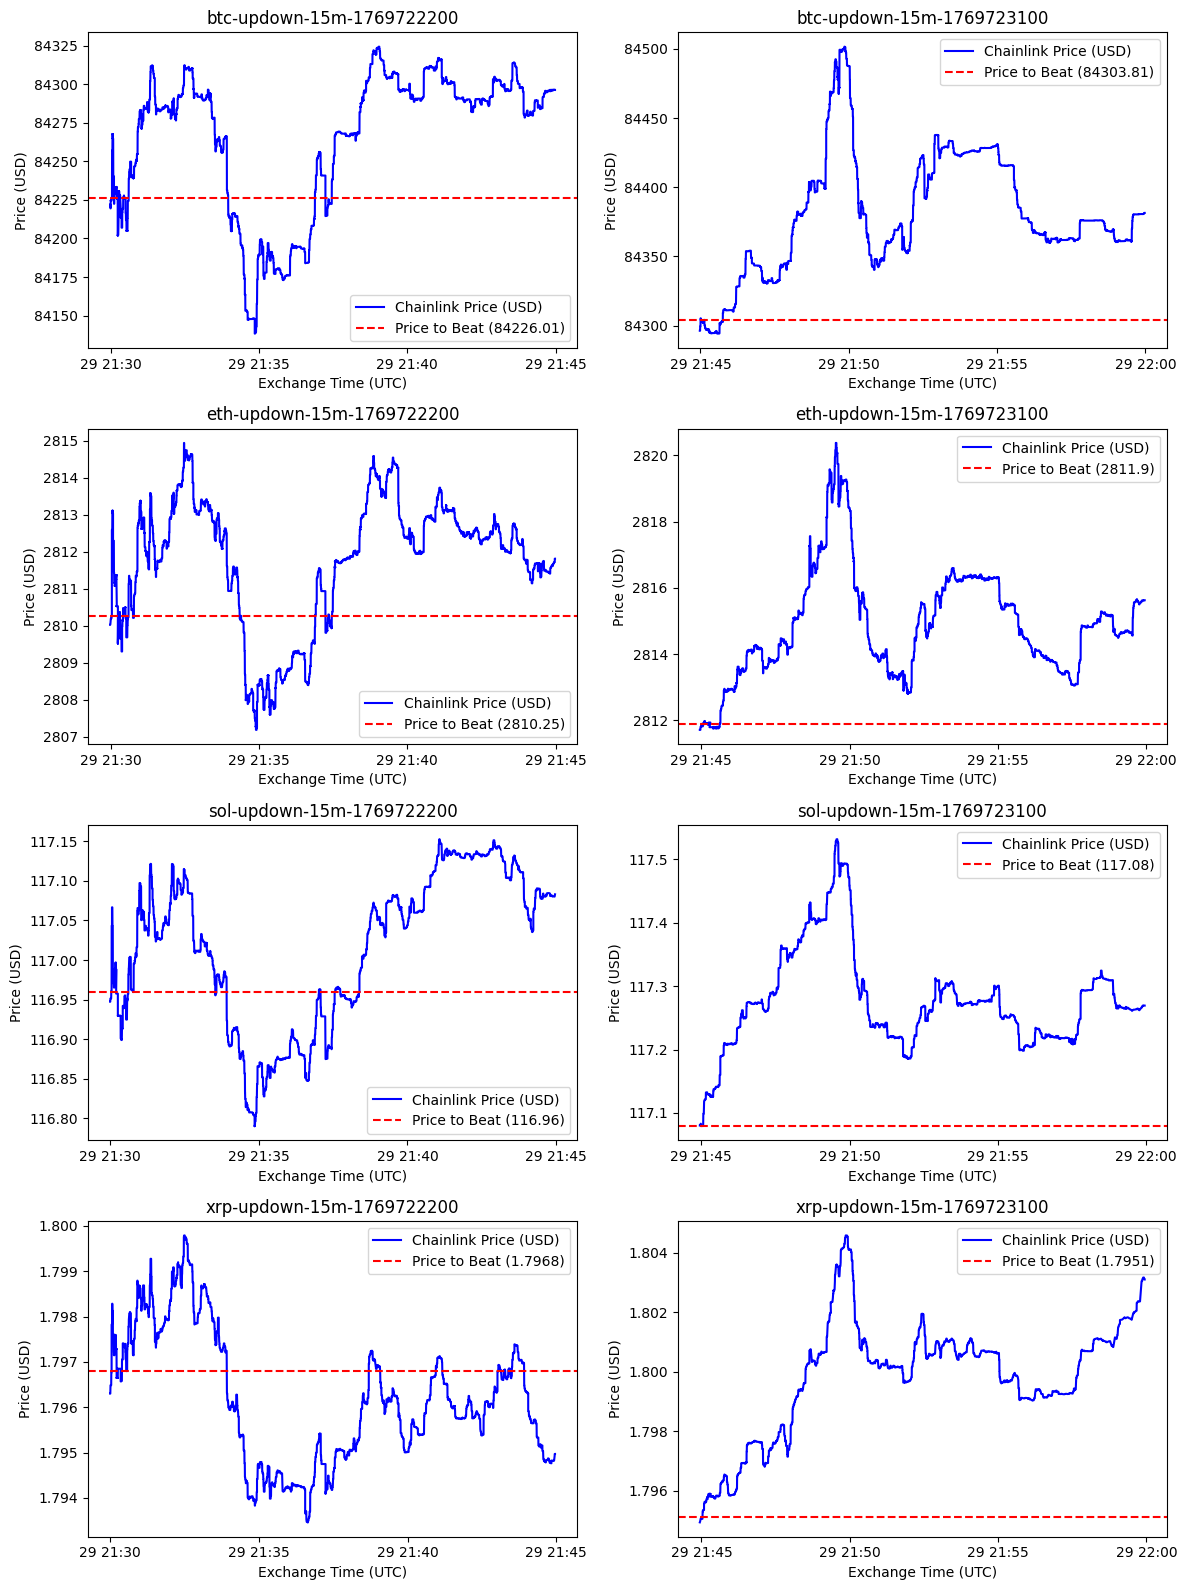

In [182]:
# to see what the price to beat is i will check on the website for this specific market
# price to beat was $84303.81 for btc in one market
# added a mapping to see if we can find a pattern to grap the price to beat reliably 

price_to_beat = {
    'btc-updown-15m-1769723100': 84303.81,
    'btc-updown-15m-1769722200': 84226.01,
    'eth-updown-15m-1769723100': 2811.90, 
    'eth-updown-15m-1769722200': 2810.25, 
    'sol-updown-15m-1769723100': 117.08, 
    'sol-updown-15m-1769722200': 116.96, 
    'xrp-updown-15m-1769723100': 1.7951, 
    'xrp-updown-15m-1769722200': 1.7968, 
}

unique_slugs = df['slug'].dropna().unique()
slugs_with_price = [
    slug for slug in unique_slugs
    if slug in price_to_beat and not df[df['slug'] == slug].empty
]

n = len(slugs_with_price)
cols = 2
rows = (n + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, slug in enumerate(slugs_with_price):
    market = df[df['slug'] == slug]
    start_time = market['exchange_dt'].min() + pd.Timedelta(seconds=8)
    end_time = start_time + pd.Timedelta(minutes=15)
    market_20s = market[(market['exchange_dt'] >= start_time) & (market['exchange_dt'] < end_time)]
    x = market_20s['exchange_dt']
    y_cl = market_20s['chainlink_price_usd']
    axes[i].plot(x, y_cl, label='Chainlink Price (USD)', color='blue')
    axes[i].axhline(y=price_to_beat[slug], color='red', linestyle='--', label=f'Price to Beat ({price_to_beat[slug]})')
    axes[i].set_title(f"{slug}")
    axes[i].set_xlabel('Exchange Time (UTC)')
    axes[i].set_ylabel('Price (USD)')
    axes[i].legend()

for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Baseline pricing model
We are looking for a solid pricing model that can put limit orders on the bid / ask around deeper levels to farm retail hits and farm market maker rebates. 

## Definition of the 15 min up/down markets
For each market m: 
 - Resolve time: T
 - Price to beat (strike): K
 - Underlying price (chainlink) St at time t. 
The market resolves to YES if the oracle price at expiry is above the strike
 - YES pays 1 iff ST > K else pays 0
 - The fair value of YES = P(St > K | Ft)
 - Consequently you have NO markets where the fair value = 1 - YESfairvalue

## Assumptions
 - Since its very short horizons the spot price behaves like a random walk without much bias to up/down. 
 - We assume local vol is consistent as a baseline for these crypto markets.  
 - We assume that there is a scaling of uncertainty. When there is less time left in the contract there is less uncertainty.

## Pricing 
At each moment t we need to compute:
 - time left: T-t
 - distance: log(S / K)(> 0 is above strike)
 - sigma_1m: std(S.diff())

We use log returns to remain scale invariant. 

We need an input parameter that denominates the volatility per minute move, we can fit this over the last 2 hours of different markets. 
call this sigma_1m. then we plug that in the formula together with the amount of minutes left to scale for uncertainty.
 - sigma_remaining = sigma_1m * sqrt(minutes_left)

We compute a score that measures how far in vol we are away of the strike price. 
 - z = distance / sigma_remaining
  - z = 0: 50/50
  - z = +1 means 1 move above, therefore making it likely YES
  - z = -1 means 1 move below, therefore making it likely NO 

Then we convert Z into a probability:
NormalCDF(z) is the cumulative distribution function of a standard normal variable so it returns the probability that a N(0,1) random variable is <= z. 
 - YESFair = NormalCDF(z)
 - NOfair = 1 - YESFair




In [218]:
DATA_DIR = Path("data") 
ASSET = "sol"
N = 20

files = sorted(DATA_DIR.glob(f"{ASSET}-*.csv"))[:N]
dfs = []

for fp in files:
    meta = {}
    with open(fp, "r", encoding="utf-8") as f:
        for line in f:
            if line.startswith("# end_market_metadata"):
                break
            if line.startswith("# ") and "=" in line:
                k, v = line[2:].strip().split("=", 1)
                meta[k] = v

    df = pd.read_csv(fp, comment="#")
    df["file"] = fp.name
    df["slug"] = meta.get("slug")
    df["asset"] = meta.get("asset", ASSET)
    df["start_time"] = meta.get("start_time")
    df["closed_time"] = meta.get("closed_time")
    df["resolved_outcome"] = meta.get("resolved_outcome")

    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df["exchange_dt"] = pd.to_datetime(df["exchange_timestamp_ms"], unit="ms", utc=True, errors="coerce")

print("rows:", len(df), "| markets:", df["slug"].nunique(), "| files:", len(files))
display(df.head(3))
print(df["slug"].dropna().unique()[:10])


rows: 690551 | markets: 11 | files: 11


,slug,asset,outcome,exchange_timestamp_ms,exchange_timestamp_utc,insertion_timestamp_utc,chainlink_price_usd,chainlink_timestamp_ms,chainlink_age_ms,binance_price_usdt,...,bid_size_2,bid_size_3,bid_size_4,bid_size_5,chainlink_found,file,start_time,closed_time,resolved_outcome,exchange_dt
0,sol-updown-15m-1769721300,sol,YES,1769721305096,2026-01-29T21:15:05.096000+00:00,2026-01-29T21:15:05.168900+00:00,117.069565,1769721303000,2096,117.28,...,330.0,312.50,307.50,313.0,True,sol-2026-01-29-21_15-21_30.csv,2026-01-29T21:15:00Z,2026-01-29T21:30:00+00:00,Down,2026-01-29 21:15:05.096000+00:00
1,sol-updown-15m-1769721300,sol,NO,1769721305096,2026-01-29T21:15:05.096000+00:00,2026-01-29T21:15:05.177722+00:00,117.069565,1769721303000,2096,117.28,...,7.5,24.25,28.33,7.5,True,sol-2026-01-29-21_15-21_30.csv,2026-01-29T21:15:00Z,2026-01-29T21:30:00+00:00,Down,2026-01-29 21:15:05.096000+00:00
2,sol-updown-15m-1769721300,sol,YES,1769721305277,2026-01-29T21:15:05.277000+00:00,2026-01-29T21:15:05.205172+00:00,117.069565,1769721303000,2277,117.28,...,322.5,312.50,307.50,313.0,True,sol-2026-01-29-21_15-21_30.csv,2026-01-29T21:15:00Z,2026-01-29T21:30:00+00:00,Down,2026-01-29 21:15:05.277000+00:00


['sol-updown-15m-1769721300' 'sol-updown-15m-1769722200'
 'sol-updown-15m-1769723100' 'sol-updown-15m-1769724000'
 'sol-updown-15m-1769724900' 'sol-updown-15m-1769725800'
 'sol-updown-15m-1769726700' 'sol-updown-15m-1769727600'
 'sol-updown-15m-1769728500' 'sol-updown-15m-1769729400']


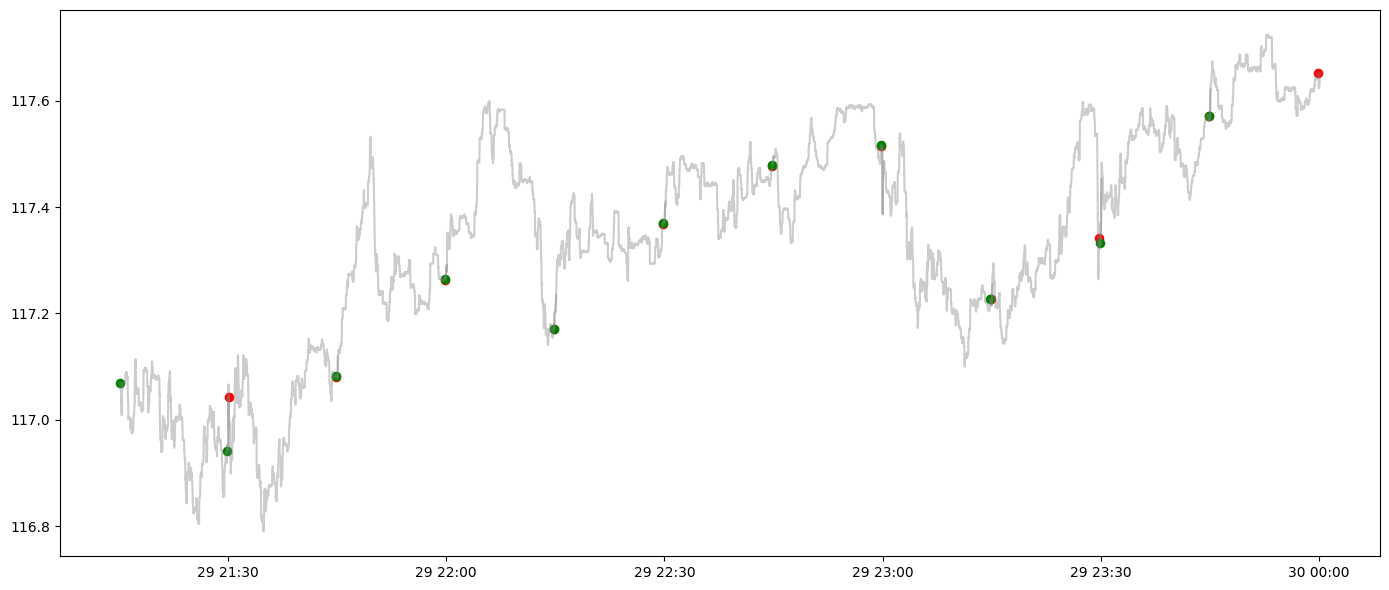

In [219]:
plt.figure(figsize=(14,6))

for slug, g in df.dropna(subset=["exchange_dt", "chainlink_price_usd"]).groupby("slug"):
    g = g.sort_values("exchange_dt")
    st = g["exchange_dt"].iloc[0]
    et = st + pd.Timedelta(minutes=15)

    start_px = float(g["chainlink_price_usd"].iloc[0])

    gg = g[g["exchange_dt"] <= et]
    if len(gg) == 0:
        continue
    end_px = float(gg["chainlink_price_usd"].iloc[-1])

    plt.plot(g["exchange_dt"], g["chainlink_price_usd"], color="grey", alpha=0.4)
    plt.scatter([st], [start_px], color="green", s=35)
    plt.scatter([et], [end_px], color="red", s=35)

plt.tight_layout()
plt.show()

In [220]:
#fp = Path("data/sol-2026-01-29-21_15-21_30.csv") 
#df = pd.read_csv(fp, comment="#")
#df["exchange_timestamp_utc"] = pd.to_datetime(df["exchange_timestamp_utc"], utc=True, errors="coerce")
#
#LEVELS = 5
#
#slug = df["slug"].dropna().unique()[0]
#g = df[df["slug"] == slug].copy()
#g["exchange_timestamp_utc"] = pd.to_datetime(g["exchange_timestamp_utc"], utc=True, errors="coerce")
#g = g.dropna(subset=["exchange_timestamp_utc"]).sort_values("exchange_timestamp_utc")
#
#fig, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
#
#for j, side in enumerate(["YES", "NO"]):
#    h = g[g["outcome"] == side].dropna(subset=["bid_price_1","ask_price_1"])
#    for i in range(1, LEVELS + 1):
#        a = 0.9 * (0.6 ** (i-1))
#        ax[j].plot(h["exchange_timestamp_utc"], h[f"bid_price_{i}"], color="green", alpha=a)
#        ax[j].plot(h["exchange_timestamp_utc"], h[f"ask_price_{i}"], color="red",   alpha=a)
#    ax[j].set_title(f"{side} book: {slug}")
#    ax[j].set_ylim(0, 1)
#    ax[j].grid(True, alpha=0.2)
#
#plt.tight_layout()
#plt.show()

In [221]:
df["exchange_timestamp_utc"] = pd.to_datetime(df["exchange_timestamp_utc"], utc=True, errors="coerce")
df = df.dropna(subset=["exchange_timestamp_utc","chainlink_price_usd"]).sort_values(["slug","exchange_timestamp_utc"]).copy()

df["T"] = df.groupby("slug")["exchange_timestamp_utc"].transform("min") + pd.Timedelta(minutes=15)
df["minutes_left"] = (df["T"] - df["exchange_timestamp_utc"]).dt.total_seconds() / 60


In [222]:
df.head(3)

,slug,asset,outcome,exchange_timestamp_ms,exchange_timestamp_utc,insertion_timestamp_utc,chainlink_price_usd,chainlink_timestamp_ms,chainlink_age_ms,binance_price_usdt,...,bid_size_4,bid_size_5,chainlink_found,file,start_time,closed_time,resolved_outcome,exchange_dt,T,minutes_left
0,sol-updown-15m-1769721300,sol,YES,1769721305096,2026-01-29 21:15:05.096000+00:00,2026-01-29T21:15:05.168900+00:00,117.069565,1769721303000,2096,117.28,...,307.50,313.0,True,sol-2026-01-29-21_15-21_30.csv,2026-01-29T21:15:00Z,2026-01-29T21:30:00+00:00,Down,2026-01-29 21:15:05.096000+00:00,2026-01-29 21:30:05.096000+00:00,15.000000
1,sol-updown-15m-1769721300,sol,NO,1769721305096,2026-01-29 21:15:05.096000+00:00,2026-01-29T21:15:05.177722+00:00,117.069565,1769721303000,2096,117.28,...,28.33,7.5,True,sol-2026-01-29-21_15-21_30.csv,2026-01-29T21:15:00Z,2026-01-29T21:30:00+00:00,Down,2026-01-29 21:15:05.096000+00:00,2026-01-29 21:30:05.096000+00:00,15.000000
2,sol-updown-15m-1769721300,sol,YES,1769721305277,2026-01-29 21:15:05.277000+00:00,2026-01-29T21:15:05.205172+00:00,117.069565,1769721303000,2277,117.28,...,307.50,313.0,True,sol-2026-01-29-21_15-21_30.csv,2026-01-29T21:15:00Z,2026-01-29T21:30:00+00:00,Down,2026-01-29 21:15:05.277000+00:00,2026-01-29 21:30:05.096000+00:00,14.996983


### Plotting 2h rolling vol
We defined vol as the standard deviation of the price now - price 1min ago

sigma_1m_2h NaN %: 22.45
sigma_1m_2h min/median/max: 0.000513086231555945 0.0005872960752481747 0.0006966892124950389


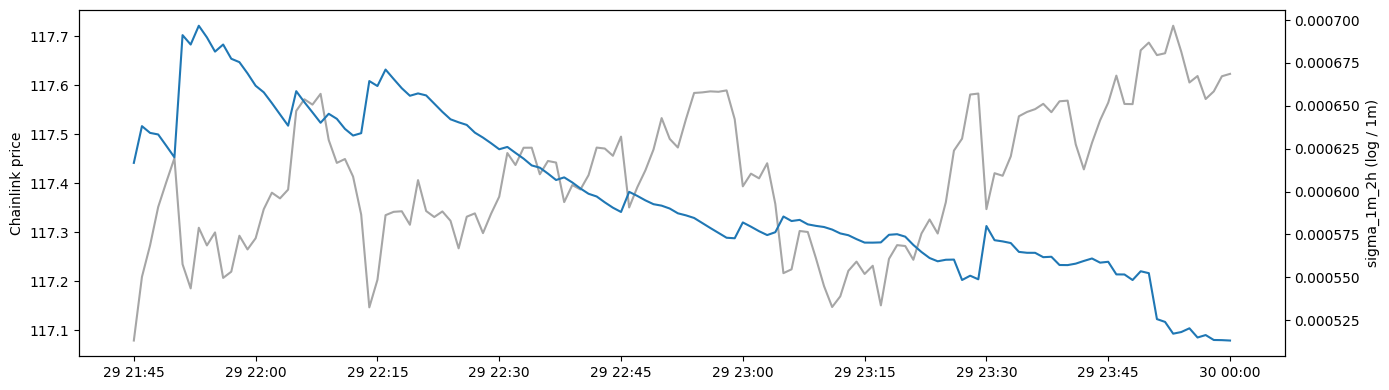

In [223]:
df["exchange_timestamp_utc"] = pd.to_datetime(df["exchange_timestamp_utc"], utc=True, errors="coerce")
df["minute"] = df["exchange_timestamp_utc"].dt.floor("min")

cl = (df[["minute","chainlink_price_usd"]]
      .dropna()
      .drop_duplicates("minute")
      .sort_values("minute")
      .set_index("minute")["chainlink_price_usd"]
      .resample("1min").last().ffill())

sigma_1m_2h = np.log(cl).diff().rolling(120, min_periods=30).std()
df["sigma_1m_2h"] = df["minute"].map(sigma_1m_2h)

print("sigma_1m_2h NaN %:", round(df["sigma_1m_2h"].isna().mean()*100, 2))
print("sigma_1m_2h min/median/max:", df["sigma_1m_2h"].min(), df["sigma_1m_2h"].median(), df["sigma_1m_2h"].max())

tmp = (df.dropna(subset=["exchange_timestamp_utc","chainlink_price_usd","sigma_1m_2h"])
         .drop_duplicates("minute")
         .sort_values("minute"))

fig, ax1 = plt.subplots(figsize=(14,4))
ax1.plot(tmp["minute"], tmp["chainlink_price_usd"], color="grey", alpha=0.7)
ax1.set_ylabel("Chainlink price")

ax2 = ax1.twinx()
ax2.plot(tmp["minute"], tmp["sigma_1m_2h"])
ax2.set_ylabel("sigma_1m_2h (log / 1m)")

fig.tight_layout()
plt.show()


In [224]:
dfp = (df.dropna(subset=["sigma_1m_2h","chainlink_price_usd","exchange_timestamp_utc","minutes_left"])
         .sort_values(["slug","exchange_timestamp_utc"])
         .copy())

dfp["K"] = dfp.groupby("slug")["chainlink_price_usd"].transform("first")
dfp["distance"] = np.log(dfp["chainlink_price_usd"] / dfp["K"])

t = np.maximum(dfp["minutes_left"].to_numpy(), 1e-9)
dfp["sigma_remaining"] = dfp["sigma_1m_2h"] * np.sqrt(t)
dfp["z"] = dfp["distance"] / np.maximum(dfp["sigma_remaining"], 1e-12)

dfp["YESFair"] = dfp["z"].clip(-8, 8).apply(lambda x: 0.5*(1 + math.erf(x / math.sqrt(2))))
dfp["NOfair"] = 1 - dfp["YESFair"]

print("rows:", len(dfp), "| markets:", dfp["slug"].nunique())
display(dfp[["slug","exchange_timestamp_utc","minutes_left","sigma_1m_2h","z","YESFair"]].head(3))


rows: 534597 | markets: 10


,slug,exchange_timestamp_utc,minutes_left,sigma_1m_2h,z,YESFair
154846,sol-updown-15m-1769722200,2026-01-29 21:45:00.020000+00:00,-0.161117,0.000617,0.0,0.5
154847,sol-updown-15m-1769722200,2026-01-29 21:45:00.020000+00:00,-0.161117,0.000617,0.0,0.5
154848,sol-updown-15m-1769722200,2026-01-29 21:45:00.097000+00:00,-0.162400,0.000617,0.0,0.5


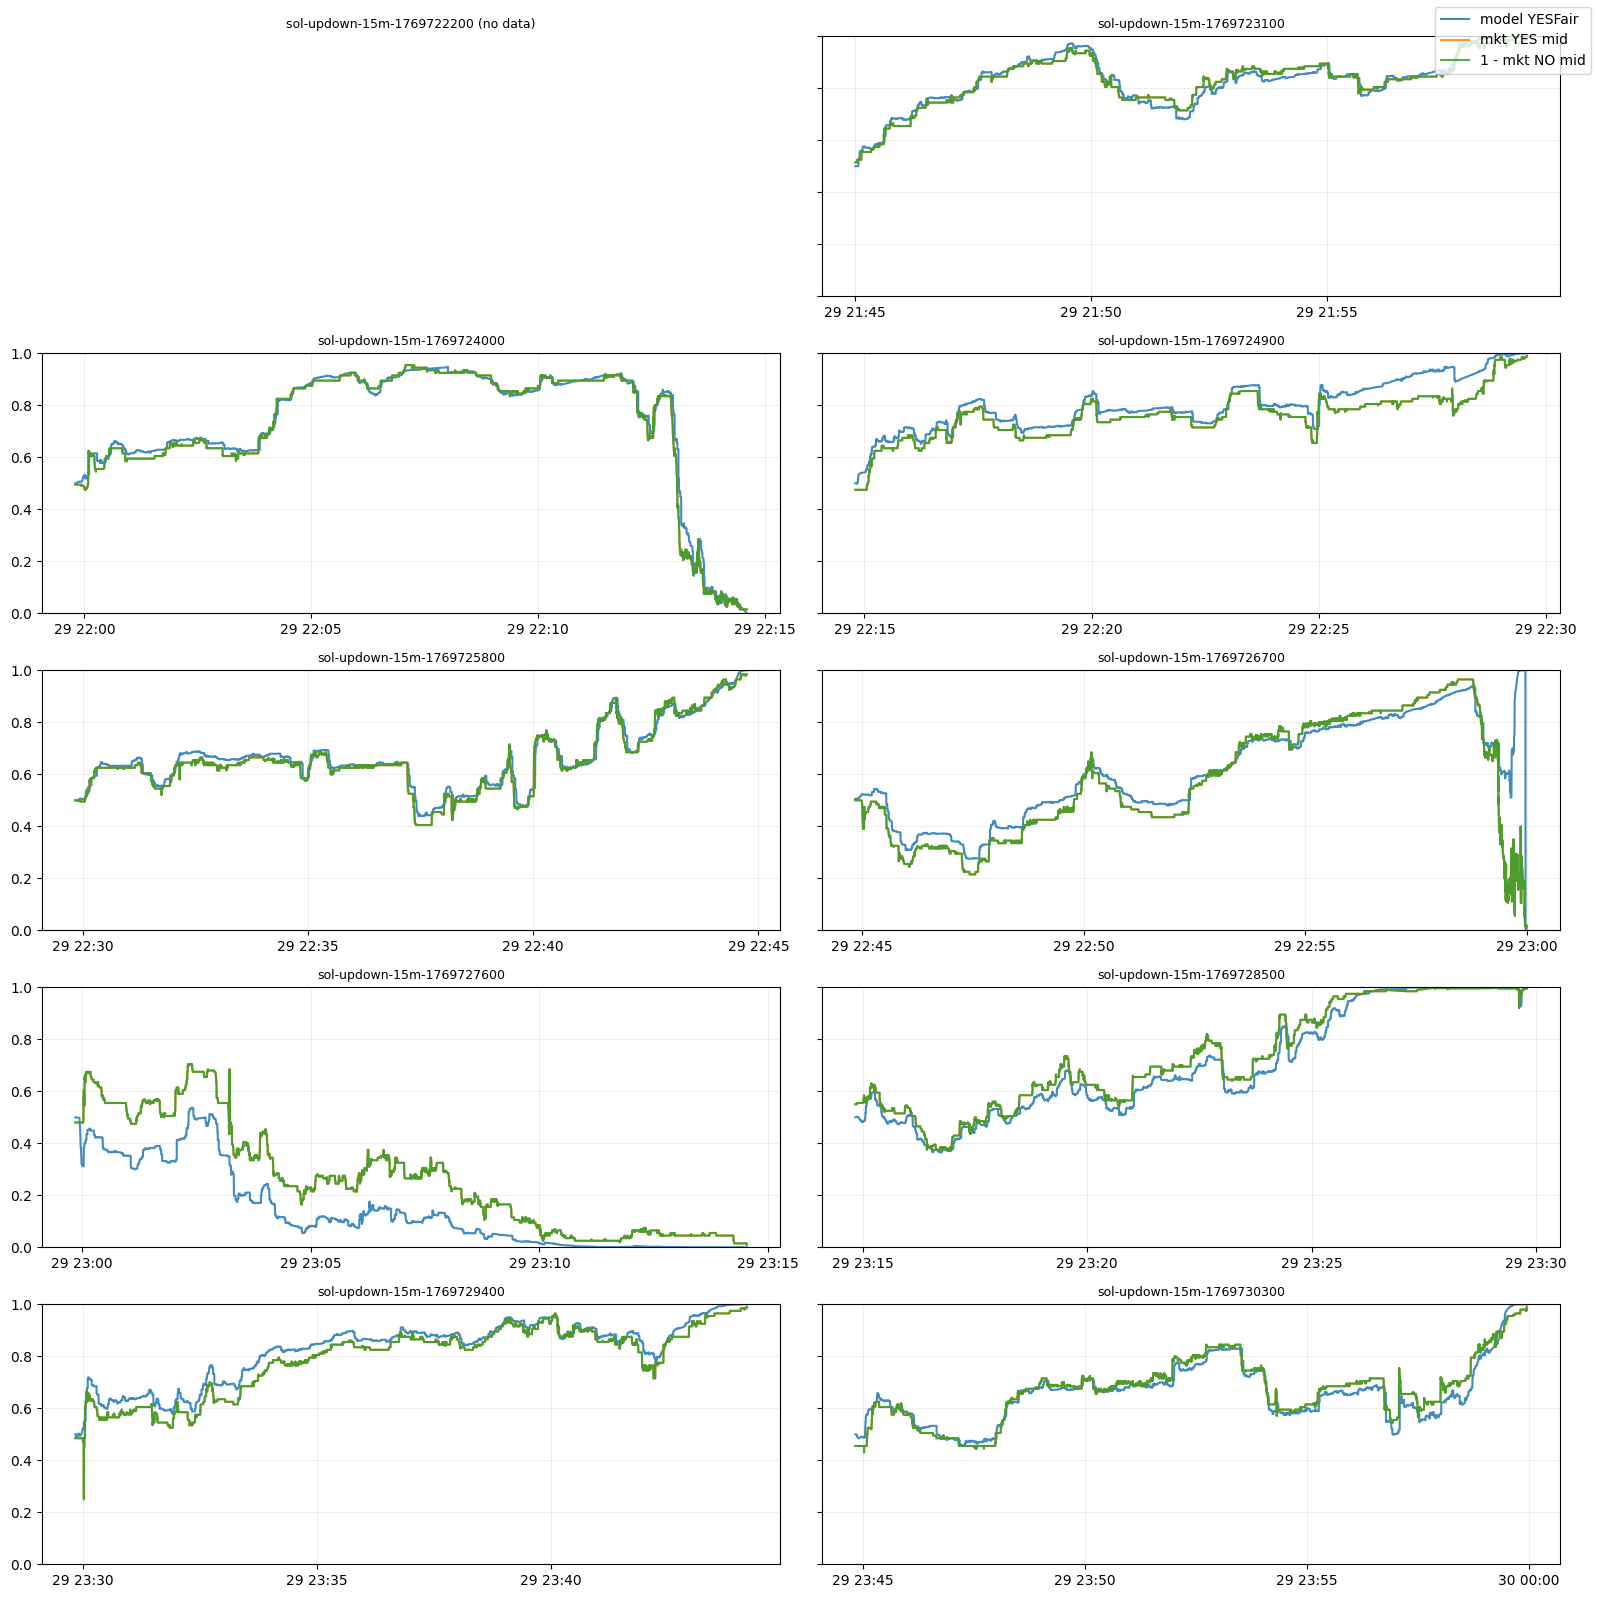

In [225]:
slugs = dfp.loc[dfp["outcome"].eq("YES"), "slug"].dropna().unique()[:20]

n = len(slugs)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3.2*nrows), sharey=True)
axes = np.array(axes).reshape(nrows, ncols)

handles = None

for i, slug in enumerate(slugs):
    ax = axes[i // ncols, i % ncols]

    yes = (dfp[(dfp["slug"]==slug) & (dfp["outcome"]=="YES")]
           .dropna(subset=["exchange_timestamp_utc","YESFair","bid_price_1","ask_price_1"])
           .sort_values("exchange_timestamp_utc")
           .drop_duplicates("exchange_timestamp_utc", keep="last"))

    no = (dfp[(dfp["slug"]==slug) & (dfp["outcome"]=="NO")]
          .dropna(subset=["exchange_timestamp_utc","bid_price_1","ask_price_1"])
          .sort_values("exchange_timestamp_utc")
          .drop_duplicates("exchange_timestamp_utc", keep="last"))

    if len(yes) == 0 or len(no) == 0:
        ax.set_title(f"{slug} (no data)", fontsize=9)
        ax.axis("off")
        continue

    m = pd.merge_asof(
        yes[["exchange_timestamp_utc","YESFair","bid_price_1","ask_price_1"]].rename(
            columns={"bid_price_1":"yes_bid","ask_price_1":"yes_ask"}
        ),
        no[["exchange_timestamp_utc","bid_price_1","ask_price_1"]].rename(
            columns={"bid_price_1":"no_bid","ask_price_1":"no_ask"}
        ),
        on="exchange_timestamp_utc",
        direction="nearest",
        tolerance=pd.Timedelta("1s")
    ).dropna()

    if len(m) == 0:
        ax.set_title(f"{slug} (no aligned)", fontsize=9)
        ax.axis("off")
        continue

    market_yes_fair = 0.5 * (m["yes_bid"] + m["yes_ask"])
    market_no_fair  = 0.5 * (m["no_bid"]  + m["no_ask"])

    l1, = ax.plot(m["exchange_timestamp_utc"], m["YESFair"], label="model YESFair", alpha=0.85)
    l2, = ax.plot(m["exchange_timestamp_utc"], market_yes_fair, label="mkt YES mid", alpha=0.85)
    l3, = ax.plot(m["exchange_timestamp_utc"], 1 - market_no_fair, label="1 - mkt NO mid", alpha=0.85)

    ax.set_ylim(0, 1)
    ax.set_title(slug, fontsize=9)
    ax.grid(True, alpha=0.2)

    if handles is None:
        handles = [l1, l2, l3]

for j in range(n, nrows*ncols):
    axes[j // ncols, j % ncols].axis("off")

fig.legend(handles=handles, labels=[h.get_label() for h in handles], loc="upper right")
plt.tight_layout()
plt.show()


In [217]:
print([c for c in dfp.columns if "ask" in c.lower()])
print([c for c in dfp.columns if "bid" in c.lower()])


['ask_price_1', 'ask_price_2', 'ask_price_3', 'ask_price_4', 'ask_price_5', 'ask_size_1', 'ask_size_2', 'ask_size_3', 'ask_size_4', 'ask_size_5']
['bid_price_1', 'bid_price_2', 'bid_price_3', 'bid_price_4', 'bid_price_5', 'bid_size_1', 'bid_size_2', 'bid_size_3', 'bid_size_4', 'bid_size_5']


In [ ]:
dfp[["bid_price_1","ask_price_1"]].dtypes


bid_price_1    float64
ask_price_1    float64
dtype: object

In [ ]:
dfp["ask_price_1"].min(), dfp["ask_price_1"].max()


(nan, nan)

In [ ]:
dfp["exchange_timestamp_utc"] = pd.to_datetime(dfp["exchange_timestamp_utc"], utc=True, errors="coerce")

g = dfp[(dfp["slug"]==slug) & (dfp["outcome"]=="YES")].copy()
g = g.sort_values("exchange_timestamp_utc")


In [ ]:
g

,slug,asset,outcome,exchange_timestamp_ms,exchange_timestamp_utc,insertion_timestamp_utc,chainlink_price_usd,chainlink_timestamp_ms,chainlink_age_ms,binance_price_usdt,...,T,minutes_left,K,distance,minute,sigma_1m_2h,sigma_remaining,z,YESFair,NOfair
